# Quantifying OCR Accuracy in Newspaper Data

This notebook aims to quantify the Optical Character Recognition (OCR) accuracy of data from three newspapers: Leeuwarder Courant, Het Parool, and Trouw. We will focus on book review articles from these newspapers and evaluate OCR accuracy by determining the percentage of words that appear in Dutch or German dictionaries. German dictionaries are included in the analysis because several German books are reviewed in these articles.

It's important to note that this method provides an indication of OCR accuracy rather than an exact measure, as not every word or derivative is necessarily present in the dictionaries used. Nonetheless, this approach can reveal trends and noteworthy patterns in the OCR quality for the datasets.

The main steps involved in this notebook are:
1. **Data Loading:** Importing the book review articles from the three newspapers.
2. **Preprocessing:** Cleaning and preparing the text for analysis.
3. **Dictionary Matching:** Comparing the words in the articles against Dutch and German dictionaries.
4. **Accuracy Calculation:** Quantifying OCR accuracy by calculating the percentage of dictionary-matched words.
5. **Visualisation over time:** Showing the results overtime to determine trend and other patterns.

Let's get started!


In [1]:
import pandas as pd
import numpy as np
import string
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import words

import requests
from tqdm import tqdm
from functools import lru_cache
from concurrent.futures import ThreadPoolExecutor

import matplotlib.pyplot as plt


# Ensure you have the necessary NLTK tokenizer models downloaded
nltk.download('punkt')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\niels\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\niels\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
def remove_extra_spaces(text):
    if not (type(text) == str):
        return np.nan
    # Replace multiple spaces with a single space
    cleaned_text = re.sub(r'\s+', ' ', text)
    return cleaned_text.strip()

In [4]:
# Load data from Excel and CSV files into DataFrames

# Load leeuwarde courant Excel file into a DataFrame
df_lc = pd.read_excel('../data/raw/manullay_check_partially_matched_titles.xlsx', engine='openpyxl')

# Load Trouw and Het Parool annotated book review file into a DataFrame
df_trouw_parool = pd.read_csv('../data/raw/trouw_and_parool_annotated_book_titles.csv')

In [5]:
df_lc['content'] = df_lc['content'].apply(remove_extra_spaces)

In [6]:
df_lc

,Column1,IdR,IdR_add,Id_Pub1,dateRev,yearRev,title1,title2,name,name1,name2,Id_Pers,givenName,familyName,fullName,alternateName,place,publisher,publisher2,publisherId,translationOfWork,genre,ISBN,bookFormat,birthDate,deathDate,subject2,subject3,publicationId,yearPub,bookEdition,numberOfPages,comment,description,inLanguage,isPartOf,subject1,genreNews,PiCartaDNB,Manual,content,title_in_content,title3,partially_matched,title4,partially_matched_original_title,manually_removed
0,0.0,100001,100001_a,p04763894X,1979-11-24,1979,Atlantische avond : gedichten / Theun de Vries...,Atlantische avond : gedichten,Theun de Vries,Theun de,Vries,p068302770,Theun,de Vries,"Vries, Theun de (1907-2005)","P'risi, T'ein de",Buitenpost,Lykele Jansma in samenw. met de Literaire Krin...,Lykele Jansma,_:b7849391,NaN,Book,9062721915,PrintBook,1907,2005,NaN,NaN,_:b12370168,1979,NaN,[20] bl,Med. NLMD,NaN,ned,NaN,NaN,artikel,NaN,NaN,Camperts Theater Overigens is de titel van dez...,False,atlantische avond,0,atlantische avond,NONE,0
1,1.0,100001,100001_b,p790195607,1979-11-24,1979,Huis en tuin : fabels en strips / [door] Leo V...,Huis en tuin : fabels en strips,Leo Vroman,Leo,Vroman,p068433026,Leo,Vroman,"Vroman, Leo (1915-2014)",NaN,Amsterdam,Querido,Querido,_:b9649699,NaN,Book,9021486806,PrintBook,1915,2014,NaN,NaN,_:b14170476,1979,NaN,"40 p., [12] bl. pl",Med. NLMD,NaN,ned,NaN,NaN,artikel,NaN,NaN,Camperts Theater Overigens is de titel van dez...,False,huis en tuin,0,huis en tuin,NONE,0
2,2.0,100001,100001_c,p780280946,1979-11-24,1979,Volledig volmaakte oneetbare perzik / [door] G...,Volledig volmaakte oneetbare perzik,Gerrit Kouwenaar,Gerrit,Kouwenaar,p068390394,Gerrit,Kouwenaar,"Kouwenaar, Gerrit (1923-2014)","Kauvenar, Gerrit",Amsterdam,Querido,Querido,_:b9276628,NaN,Book,9021471418,PrintBook,1923,2014,NaN,NaN,_:b13797405,1978,NaN,64 p,Med. NLMD,NaN,ned,NaN,NaN,artikel,NaN,NaN,Camperts Theater Overigens is de titel van dez...,False,volledig volmaakte oneetbare perzik,0,volledig volmaakte oneetbare perzik,NONE,0
3,3.0,100001,100001_d,p050474774,1979-11-24,1979,Goede morgen haan / door Gerrit Kouwenaar [tek...,Goede morgen haan,Gerrit Kouwenaar,Gerrit,Kouwenaar,p068390394,Gerrit,Kouwenaar,"Kouwenaar, Gerrit (1923-2014)","Kauvenar, Gerrit",Nijmegen,Thieme,Thieme,_:b7971295,NaN,Book,NaN,PrintBook,1923,2014,NaN,NaN,_:b12492072,1978,NaN,[16] p,Med. NLMD,Facs. herdr. van uitg.: Amsterdam : Experiment...,ned,NaN,NaN,artikel,NaN,NaN,Camperts Theater Overigens is de titel van dez...,False,goede morgen haan,0,goede morgen haan,NONE,0
4,4.0,100001,100001_e,p161840841,1979-11-24,1979,Het weerlicht op de kimmen : een keuze uit de ...,Het weerlicht op de kimmen : een keuze uit de ...,Gerrit Achterberg,Gerrit,Achterberg,p068390343,Gerrit,Achterberg,"Achterberg, Gerrit (1905-1962 ; dichter)",\u0410\u0445\u0442\u0435\u0440\u0431\u0435\u04...,Amsterdam,Querido,Querido,_:b8602066,NaN,Book,9021450291,PrintBook,1905,1962,NaN,NaN,_:b13122843,1979,2e dr,167 p,Med. NLMD,1e uitg.: 1965,ned,QED,NaN,artikel,NaN,NaN,Camperts Theater Overigens is de titel van dez...,True,Het weerlicht op de kimmen,1,het weerhcht op de kimmen;,het weerlicht op de kimmen,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25935,NaN,100011976,neg_100011976_1,p801624509,1976-02-16,1976,Berichten voor bezorgde kinderen / door Willem...,Berichten voor bezorgde kinderen,Willem Wilmink,Willem,Wilmink,p06832927X,Willem,Wilmink,"Wilmink, Willem (1936-2003)",NaN,Amsterdam,Kosmos,Kosmos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48 p,NaN,NaN,ned,NaN,NaN,artikel,NaN,NaN,"boeken Handzame, maar geen vrijblijvende kinde...",True,NaN,0,Berichten voor bezorgde kinderen,NONE,0
25936,NaN,100011976,neg_100011976_2,p802042015,1976-02-16,1976,De verjaardag / Marguerita Rudolph ; [vert. ui...,De verjaardag,Marguerita Rudolph,Marguerita,Rudolph,NaN,NaN,NaN,NaN,NaN,Amsterdam,Kosmo

In [7]:
# Load the OpenTaal word list
with open('../word_dictionary/OpenTaal-210G-basis-gekeurd.txt', 'r') as file:
    dutch_words = set(word.strip().lower() for word in file.readlines())

In [8]:
len(dutch_words)

164105

In [9]:
# Load the OpenTaal word list with the correct encoding
with open('../word_dictionary/openthesaurus.txt', 'r', encoding='utf-8') as file:
    german_words = set(word.strip().lower() for word in file.readlines())

german_dict1 = set()

# Iterate through each string in the multi-word set
for multi_word in german_words:
    # Remove parentheses and their contents
    multi_word = re.sub(r'\(.*?\)', '', multi_word)
    # Split the string by semicolons and spaces, and add each word to the set
    words = re.split(r'[; ]+', multi_word)
    german_dict1.update(word.strip() for word in words if word.strip())

In [10]:
with open('../word_dictionary/de_DE.dic', 'r') as file:
    german_words = set(word.strip().lower() for word in file.readlines())

# Remove the trailing '/...' part from each word
german_words = set(word.split('/')[0] for word in german_words)

In [11]:
german_words.update(german_dict1)

In [12]:
len(german_words)

164913

In [13]:
def check_word_in_both_dictionaries(word):
    word = word.lower()
    if word in dutch_words:
        return True
    elif word in german_words:
        return True
    else: 
        return False

# Define a function to calculate the percentage of words that exist in both dictionaries for each sentence
def calculate_both_dictionaries_percentage(sentence):
    words = sentence.split()
    total_words = len(words)
    both_count = sum(1 for word in words if check_word_in_both_dictionaries(word))
    both_percentage = (both_count / total_words) * 100
    return both_percentage

In [14]:
df_lc_unique = df_lc[['yearRev', 'content']].drop_duplicates()
df_lc_unique

,yearRev,content
0,1979,Camperts Theater Overigens is de titel van dez...
8,1972,INGEBOEKT * PANDA en KAPPIE. De avonturen van ...
15,1985,"Boeken Familiekroniek, à la García Marquez deb..."
16,1981,boeken Deltas fotoboek goed basiswerk HARRY PA...
17,1981,Ingeboekt * RAYMOND RADIGUET - „Het bal van gr...
...,...,...
25925,1966,Boeken voor: Kleuters en kwajongens Voor de kl...
25929,1979,"Proza van Eric Terduyn, Aleida Leeuwenberg en ..."
25932,1989,Dood van een komiek J. BERNLEF - Vallende ster...
25933,1988,Vederlichte verhaaltjes Kees van Kooten zoekt ...


In [16]:
df_trouw_parool_unique = df_trouw_parool[['newspaper', 'text', 'year']].drop_duplicates()

In [17]:
df_lc_unique['correct_ocr_percentage'] = df_lc_unique['content'].apply(calculate_both_dictionaries_percentage)
df_trouw_parool_unique['correct_ocr_percentage'] = df_trouw_parool_unique['text'].apply(calculate_both_dictionaries_percentage)

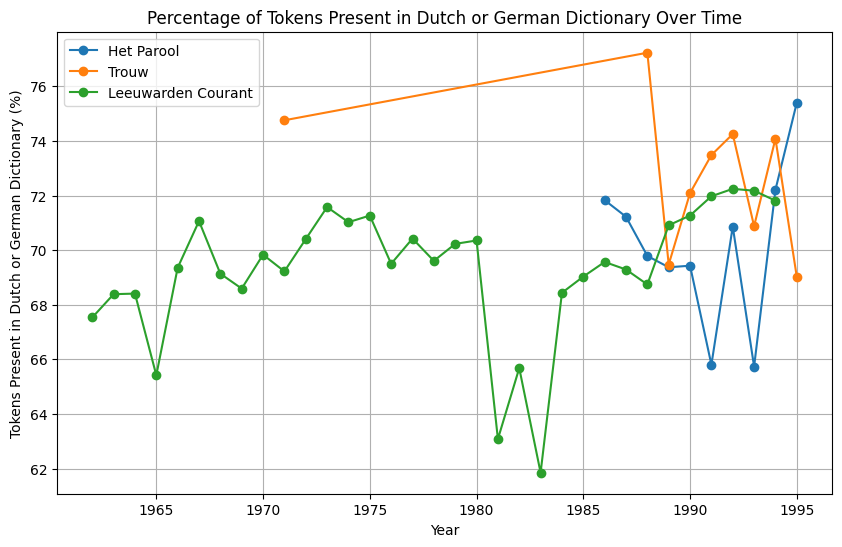

In [21]:
# Group by 'year' and calculate the mean of 'correct_ocr_percentage' for the first dataset
aggregated_data_trouw_parool = df_trouw_parool_unique.groupby(['newspaper', 'year'])['correct_ocr_percentage'].mean().reset_index()

# Group by 'yearRev' and calculate the mean of 'correct_ocr_percentage' for the second dataset
aggregated_data_lc = df_lc_unique.groupby('yearRev')['correct_ocr_percentage'].mean().reset_index()

# Plotting the data
plt.figure(figsize=(10, 6))

# Plot for the first dataset
plt.plot(aggregated_data_trouw_parool[aggregated_data_trouw_parool['newspaper'] == 'Parool']['year'], 
         aggregated_data_trouw_parool[aggregated_data_trouw_parool['newspaper'] == 'Parool']['correct_ocr_percentage'], 
         marker='o', 
         label='Het Parool')

# Plot for the first dataset
plt.plot(aggregated_data_trouw_parool[aggregated_data_trouw_parool['newspaper'] == 'Trouw']['year'], 
         aggregated_data_trouw_parool[aggregated_data_trouw_parool['newspaper'] == 'Trouw']['correct_ocr_percentage'], 
         marker='o', 
         label='Trouw')

# Plot for the second dataset
plt.plot(aggregated_data_lc['yearRev'], aggregated_data_lc['correct_ocr_percentage'], marker='o', label='Leeuwarden Courant')

# Adding titles and labels
plt.title('Percentage of Tokens Present in Dutch or German Dictionary Over Time')
plt.xlabel('Year')
plt.ylabel('Tokens Present in Dutch or German Dictionary (%)')
plt.grid(True)

# Adding legend
plt.legend()

# Show plot
plt.show()